In [1]:
import torch 
import os, warnings

warnings.filterwarnings("ignore")

%cd /workspace/Multi_Classification_PyTorch/project

from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

# clear_output()

from pytorch_lightning import seed_everything

seed_everything(42, workers=True)


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/workspace/Multi_Classification_PyTorch/project


Global seed set to 42


In [2]:
# define the metrics.
from torchmetrics import classification

_accuracy = classification.MulticlassAccuracy(num_classes=4)
_precision = classification.MulticlassPrecision(num_classes=4)
_recall = classification.MulticlassRecall(num_classes=4,)
_f1_score = classification.MulticlassF1Score(num_classes=4,)
_aucroc = classification.MulticlassAUROC(num_classes=4,)

_confusion_matrix = classification.MulticlassConfusionMatrix(num_classes=4,)

In [3]:
# load parameters

LOG_PATH = '/workspace/Multi_Classification_PyTorch/logs'
FOLD_NUMBER = ['fold%d' % d for d in range(5)]
VERSION = '714_2.5_8'
MODEL = 'resnet'


# Total metrics 
total final metric cross 5 fold cross validtaion.

In [4]:
def get_best_ckpt(opt, fold: str):

    ckpt_path = '/workspace/Multi_Classification_PyTorch/logs/resnet'
    ckpt_path_list = os.listdir(ckpt_path)
    ckpt_path_list.sort()
    version = opt.version

    final_ckpt_list = [] 

    for i in ckpt_path_list:
        if version == i:
            final_ckpt_list.append(i)

    final_ckpt_list.sort()
    
    for name in final_ckpt_list:
        if str(opt.clip_duration) in name.split('_') and str(opt.uniform_temporal_subsample_num) in name.split('_'):
            ckpt = name

    ckpt = os.path.join(ckpt_path, ckpt, fold, 'checkpoints')
    
    Acc = 0.0

    ckpt_list = os.listdir(ckpt)
    ckpt_list.sort()
    if 'last.ckpt' in ckpt_list:
        ckpt_list.remove('last.ckpt')

    for num, l in enumerate(ckpt_list):
        acc = l[-11:-5] # accuracy

        if float(acc) > float(Acc):
            Acc = acc
            NUM = num

    return os.path.join(ckpt, ckpt_list[NUM])

# ckpt_path = get_best_ckpt('1', '8', 'fold0')

In [5]:
def get_inference(test_data, model):
        
    pred_list = []
    label_list = []

    for i, batch in enumerate(test_data):

        # input and label
        video = batch['video'].detach().cuda() # b, c, t, h, w

        label = batch['label'].detach().cuda() # b, class_num

        model.cuda().eval()

        # pred the video frames
        with torch.no_grad():
            preds = model(video)

        # when torch.size([1]), not squeeze.
        preds_softmax = torch.softmax(preds, dim=1)

        pred_list.append(preds_softmax)
        label_list.append(label)

        total_pred_list = []
        total_label_list = []

        for i in pred_list:
            for number in i:
                total_pred_list.append(number)

        for i in label_list:
            for number in i: 
                total_label_list.append(number)

    return total_pred_list, total_label_list

In [6]:
import yaml

one_condition_pred_list = []
one_condition_label_list = []

total_pred_list = []
total_label_list = []


for fold in FOLD_NUMBER:

    path = os.path.join(LOG_PATH, MODEL, VERSION, fold, 'hparams.yaml')

    # load param from file
    with open(path, 'r') as f:
        file = yaml.load(f, Loader=yaml.Loader)
    opt = file['hparams']
    opt.gpu_num = 1
    opt.batch_size = 128

    #################
    # start k Fold CV
    #################
    
    ckpt_path = get_best_ckpt(opt, fold)

    print('#' * 50)
    print('Strat %s, %s length, %s frames' % (fold, opt.clip_duration, opt.uniform_temporal_subsample_num))
    print('the data path: %s' % opt.train_path)
    print('ckpt: %s' % ckpt_path)
    model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

    data_module = WalkDataModule(opt)
    data_module.setup()
    test_data = data_module.test_dataloader()

    pred_list, label_list = get_inference(test_data, model)

    one_condition_pred_list.append(pred_list)

    one_condition_label_list.append(label_list)

# total 5 fold pred and label
for i in one_condition_pred_list:
    for number in i:
        total_pred_list.append(number)

for i in one_condition_label_list:
    for number in i: 
        total_label_list.append(number)

pred = torch.stack(total_pred_list, dim=0).cpu()   
label = torch.stack(total_label_list).cpu()

print('*' * 100)
print('the result of %s %ss %sframe:' % (VERSION, opt.clip_duration, opt.uniform_temporal_subsample_num))
print('accuracy: %s' % _accuracy(pred, label))
print('precision: %s' % _precision(pred, label))
print('recall: %s' % _recall(pred, label))
print('f1_score: %s' % _f1_score(pred, label))
print('aurroc: %s' % _aucroc(pred, label))
print('confusion_matrix: %s' % _confusion_matrix(pred, label))
print('#' * 100)


##################################################
Strat fold0, 2.5 length, 8 frames
the data path: /workspace/data/multi_class_segmentation_dataset_512/fold0
ckpt: /workspace/Multi_Classification_PyTorch/logs/resnet/714_2.5_8/fold0/checkpoints/epoch=2-val_loss=1.06-val_acc=0.4073-val_f1_score=0.3825.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/multi_class_segmentation_dataset_512/fold0
##################################################
##################################################
Strat fold1, 2.5 length, 8 frames
the data path: /workspace/data/multi_class_segmentation_dataset_512/fold1
ckpt: /workspace/Multi_Classification_PyTorch/logs/resnet/714_2.5_8/fold1/checkpoints/epoch=1-val_loss=1.24-val_acc=0.3992-val_f1_score=0.3647.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/multi_class_segmentation_dataset_512/fold1
##################################################
##################################################
Strat fold2, 2.5 length, 8 frames
the data path: /workspace/data/multi_class_segmentation_dataset_512/fold2
ckpt: /workspace/Multi_Classification_PyTorch/logs/resnet/714_2.5_8/fold2/checkpoints/epoch=10-val_loss=1.25-val_acc=0.3848-val_f1_score=0.3393.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/multi_class_segmentation_dataset_512/fold2
##################################################
##################################################
Strat fold3, 2.5 length, 8 frames
the data path: /workspace/data/multi_class_segmentation_dataset_512/fold3
ckpt: /workspace/Multi_Classification_PyTorch/logs/resnet/714_2.5_8/fold3/checkpoints/epoch=0-val_loss=1.25-val_acc=0.2510-val_f1_score=0.2013.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/multi_class_segmentation_dataset_512/fold3
##################################################
##################################################
Strat fold4, 2.5 length, 8 frames
the data path: /workspace/data/multi_class_segmentation_dataset_512/fold4
ckpt: /workspace/Multi_Classification_PyTorch/logs/resnet/714_2.5_8/fold4/checkpoints/epoch=3-val_loss=0.95-val_acc=0.6472-val_f1_score=0.6069.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/multi_class_segmentation_dataset_512/fold4
##################################################
****************************************************************************************************
the result of 714_2.5_8 2.5s 8frame:
accuracy: tensor(0.4476)
precision: tensor(0.4196)
recall: tensor(0.4476)
f1_score: tensor(0.4244)
aurroc: tensor(0.6588)
confusion_matrix: tensor([[2307,  378,    0,  876],
        [ 490,  890,    0,  254],
        [ 237,   52,    0,   51],
        [ 386,   46,    0,  642]])
####################################################################################################


In [7]:
test_acc = classification.MulticlassAccuracy(num_classes=4, top_k=1, average='weighted')
test_f1 = classification.MulticlassF1Score(num_classes=4, average='weighted')

test_acc(pred, label), test_f1(pred, label)


(tensor(0.5809), tensor(0.5748))

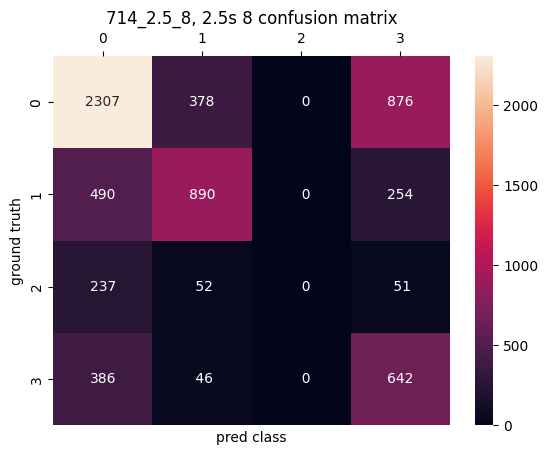

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = _confusion_matrix(pred, label)

ax = sns.heatmap(cm, annot=True, fmt="3d")

ax.set_title('%s, %ss %s confusion matrix' % (VERSION, opt.clip_duration, opt.uniform_temporal_subsample_num))
ax.set(xlabel="pred class", ylabel="ground truth")
ax.xaxis.tick_top()
plt.show()


# One fold analysis

****************************************************************************************************
the result of Fold fold4, 2.5s 8frame:
accuracy: tensor(0.4225)
precision: tensor(0.3970)
recall: tensor(0.4225)
f1_score: tensor(0.4075)
aurroc: tensor(0.7104)
confusion_matrix: tensor([[633, 144,   0,  75],
        [ 73, 374,   0,  27],
        [ 19,  48,   0,   1],
        [113,  15,   0,  24]])
####################################################################################################


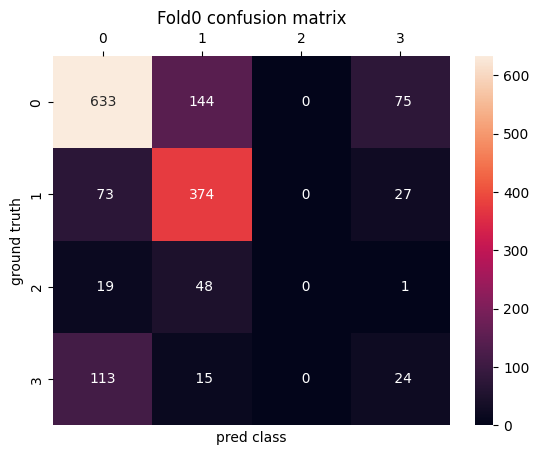

****************************************************************************************************
the result of Fold fold4, 2.5s 8frame:
accuracy: tensor(0.4079)
precision: tensor(0.4766)
recall: tensor(0.4079)
f1_score: tensor(0.3856)
aurroc: tensor(0.5871)
confusion_matrix: tensor([[454,  16,   0, 499],
        [ 68, 116,   0, 161],
        [ 15,   3,   0,  50],
        [ 72,   8,   0, 382]])
####################################################################################################


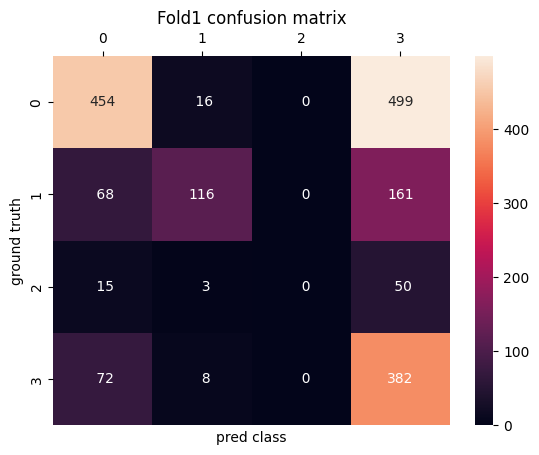

****************************************************************************************************
the result of Fold fold4, 2.5s 8frame:
accuracy: tensor(0.4317)
precision: tensor(0.3473)
recall: tensor(0.4317)
f1_score: tensor(0.3656)
aurroc: tensor(0.5458)
confusion_matrix: tensor([[230, 201,   0, 218],
        [101, 195,   0,  26],
        [ 68,   0,   0,   0],
        [ 22,  23,   0, 148]])
####################################################################################################


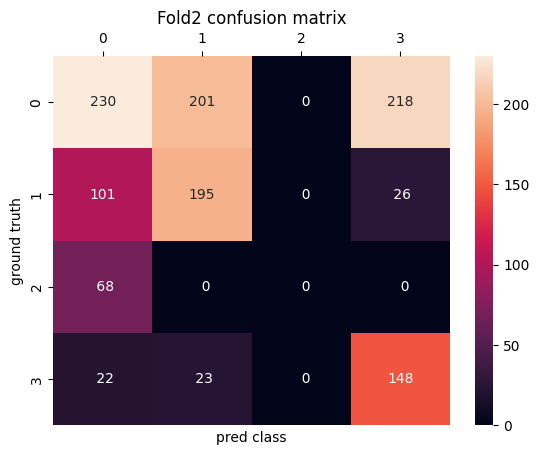

****************************************************************************************************
the result of Fold fold4, 2.5s 8frame:
accuracy: tensor(0.2572)
precision: tensor(0.3295)
recall: tensor(0.2572)
f1_score: tensor(0.2137)
aurroc: tensor(0.5627)
confusion_matrix: tensor([[454,   7,   0,  48],
        [198,  13,   0,  36],
        [ 68,   0,   0,   0],
        [174,   0,   0,  16]])
####################################################################################################


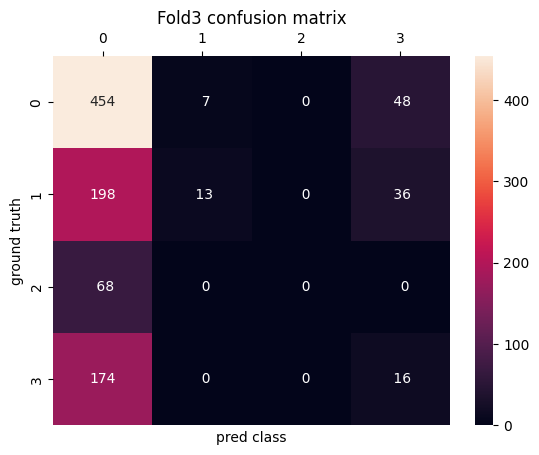

****************************************************************************************************
the result of Fold fold4, 2.5s 8frame:
accuracy: tensor(0.6591)
precision: tensor(0.6008)
recall: tensor(0.6591)
f1_score: tensor(0.6204)
aurroc: tensor(0.8506)
confusion_matrix: tensor([[536,  10,   0,  36],
        [ 50, 192,   0,   4],
        [ 67,   1,   0,   0],
        [  5,   0,   0,  72]])
####################################################################################################


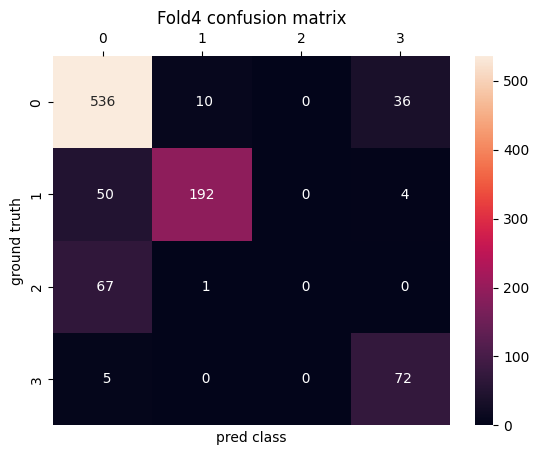

In [9]:
for i in range(len(one_condition_label_list)):
    one_batch_pred = torch.stack(one_condition_pred_list[i], dim=0).cpu()
    one_batch_label = torch.stack(one_condition_label_list[i], dim=0).cpu()

    print('*' * 100)
    print('the result of Fold %s, %ss %sframe:' % (fold, opt.clip_duration, opt.uniform_temporal_subsample_num))
    print('accuracy: %s' % _accuracy(one_batch_pred, one_batch_label))
    print('precision: %s' % _precision(one_batch_pred, one_batch_label))
    print('recall: %s' % _recall(one_batch_pred, one_batch_label))
    print('f1_score: %s' % _f1_score(one_batch_pred, one_batch_label))
    print('aurroc: %s' % _aucroc(one_batch_pred, one_batch_label))
    print('confusion_matrix: %s' % _confusion_matrix(one_batch_pred, one_batch_label))
    print('#' * 100)

    cm = _confusion_matrix(one_batch_pred, one_batch_label)
    ax = sns.heatmap(cm, annot=True, fmt="3d")

    ax.set_title('Fold%d confusion matrix' % i)
    ax.set(xlabel="pred class", ylabel="ground truth")
    ax.xaxis.tick_top()
    plt.show()

# File number count 
count different fold file, and analysis the difficult of the patient's video.

In [10]:
import sys 
DATA_PATH = '/workspace/data/multi_class_segmentation_dataset_512'
FOLD_NUMBER = ['fold%d' % d for d in range(5)]
DISEASE = ['ASD', 'DHS', 'HipOA', 'LCS']


fold_Dict = {}

for fold in FOLD_NUMBER:
    train_disease_Dict = {}
    val_disease_Dict = {}

    for flag in ['train', 'val']:
        for disease in DISEASE:
            temp_Dict = {}
            full_path = os.path.join(DATA_PATH, fold, flag, disease)    
            for file in sorted(os.listdir(full_path)):
                temp_Dict[file[:15]] = file.split('-')[-1].split('.')[0]
            
            if flag == 'train':
                train_disease_Dict[disease] = temp_Dict
            else:
                val_disease_Dict[disease] = temp_Dict

    fold_Dict[fold] = [train_disease_Dict, val_disease_Dict]

In [11]:
# fold > train, val > disease:number
fold_Dict['fold0'][0]

{'ASD': {'20160120_ASD_la': '0008',
  '20160426_ASD_la': '0008',
  '20160523_1_ASD_': '0008',
  '20170130_ASD_la': '20170130_ASD_lat_ (9)',
  '20170612_1_ASD_': '0054',
  '20171016_ASD_la': '20171016_ASD_lat__ (6)',
  '20171211_ASD_la': '0050',
  '20180123_ASD_la': '0018',
  '20180312_ASD_la': '0004',
  '20180521_1_ASD_': '0016',
  '20180521_2_ASD_': '0079',
  '20180723_1_ASD_': '0084',
  '20180723_2_ASD_': '0026',
  '20181029_ASD_la': '0010',
  '20181204_ASD_la': '0012',
  '20190108_ASD_la': '0004',
  '20190122_ASD_la': '0020',
  '20190507_2_ASD_': '0040',
  '20190709_ASD_la': '0008',
  '20190716_ASD_la': '0007',
  '20190805_ASD_la': '0010',
  '20190820_ASD_la': '0008',
  '20190917_ASD_la': '0077',
  '20191028_ASD_la': '0003',
  '20191125_2_ASD_': '0014',
  '20200120_ASD_la': '0004',
  '20200121_ASD_la': '0003',
  '20200309_ASD_la': '0002',
  '20200317_1_ASD_': '0007',
  '20201116_ASD_la': '0002',
  '20210112_ASD_la': '0008',
  '20210323_ASD_la': '0004',
  '20210406_ASD_la': '0034',
 

In [12]:
# plot the figure of different number for disease 

import matplotlib.pyplot as plt 

test = fold_Dict['fold0'][0]

# fold 0, train, ASD
len(test['ASD'])

36

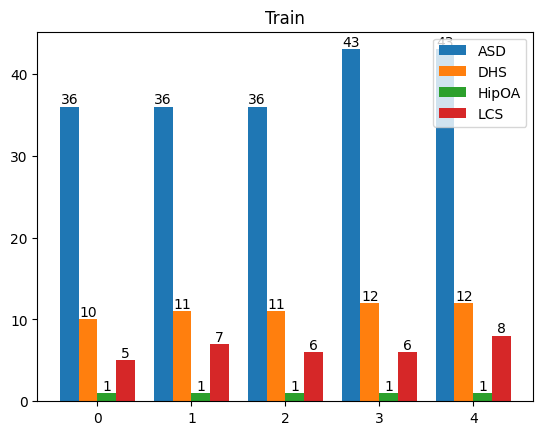

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# todo 还没写完
size = 5
x = np.arange(5)

ASD = []
DHS = []
HipOA = []
LCS = []

for k, v in fold_Dict.items():

    ASD.append(len(v[0]['ASD']))
    DHS.append(len(v[0]['DHS']))
    HipOA.append(len(v[0]['HipOA']))
    LCS.append(len(v[0]['LCS']))


total_width, n = 0.8, 4
width = total_width / n
x = x - (total_width - width) / 2

bar = plt.bar(x, ASD,  width=width, label='ASD')
# 显示数据标签
plt.bar_label(bar, label_type='edge')
bar = plt.bar(x + width, DHS, width=width, label='DHS')
plt.bar_label(bar, label_type='edge')
bar = plt.bar(x + 2 * width, HipOA, width=width, label='HipOA')
plt.bar_label(bar, label_type='edge')
bar = plt.bar(x + 3 * width, LCS, width=width, label='LCS')
plt.bar_label(bar, label_type='edge')


plt.title('Train')
plt.legend()
plt.show()